# Multilevel Gravity Survey with MLDA

### Gravity Surveying
In this example, we solve the classical 1-dimensional gravity problem, as presented in Per Christian Hansen (2010) *Discrete Inverse Problems: Insight and Algorithms*. Society for Industrial and Applied Mathematics, January 2010. The forward model is a Fredholm integral of the first kind:

\begin{equation}
    \int_{0}^{1} K(s,t) f(t) = g(s), \quad 0 \le s \le 1,
\end{equation}
where $f(t)$ is an unknown mass distribution located at depth $d$ beneath the surface, $g(s)$ is the vertical component of the gravity field at the surface, and $K(s,t)$ is known as the *kernel*, which for this particular problem has the form
\begin{equation}
    K(s,t) = \frac{d}{(d^2 + (s-t)^2)^{\frac{3}{2}}}.
\end{equation}
Since $K(s,t) = h(s-t)$, this constitutes a special case of the generic Fredholm integral, known as a *deconvolution* problem.

We solve the integral using midpoint quadrature, so that in discrete form our forward model becomes
\begin{equation}
    \sum_{j=1}^{m} \omega_j K(s_i, t_j) \hat{f}(t_j) = g(s_i), \quad i = 1, \dots, n, \quad j = 1, \dots, m
\end{equation}
where $\omega_j$ are quadrature weights, $\hat{f}(t_j)$ is the approximate subsurface mass at quadrature points $j = 1, \dots, m$, and  $g(s_i)$ is surface measurements at collocation points $i = 1, \dots, n$. Hence when $n > m$, we are dealing with an overdetermined problem and vice versa. With $t \in [0,1]$, we have
\begin{equation}
    t_j = \frac{j-\frac{1}{2}}{m} \quad \textrm{and} \quad \omega_j = \frac{1}{m}
\end{equation}
This results in a linear system $\mathbf{Ax = b}$, where
\begin{equation}
    a_{ij} = \omega_j K(s_i, t_j), \quad x_j = \hat{f}(t_j), \quad b_i = g(s_i).
\end{equation}
In this particular problem, the matrix $\mathbf{A}$ has a very high condition number, leading to an ill-posed inverse problem, which entails numerical instability and spurious, often oscillatory, solutions for noisy right hand sides. These types of problems are traditionally solved by way of some manner of *regularisation*, but hey can be handled in a natural and elegant fashion in the context of a Bayesian inverse problem.

### Mass Distribution as a Gaussian Random Process
We model the unknown mass distribution as a Gaussian Random Process with a Matern 5/2 covariance kernel (Rasmussen and Williams, 2006):
\begin{equation}
    C_{5/2}(x, x') = \sigma^2 \left( 1 + \frac{\sqrt{5} \Vert x-x' \Vert _2 }{l} + \frac{5 \Vert x-x' \Vert _2^2}{3l^2} \right) \exp \left( - \frac{\sqrt{5} \Vert x-x' \Vert _2 }{l} \right)
\end{equation}
where $l$ is the covariance length scale, $\sigma^2$ is the variance and $\Vert \cdot \Vert_2$ is the L2 norm.

### References
Per Christian Hansen. *Discrete Inverse Problems: Insight and Algorithms*. Society for Industrial and Applied Mathematics, January 2010.

Carl Edward Rasmussen and Christopher K. I. Williams. *Gaussian processes for machine learning*. Adaptive computation and machine learning. 2006.

In [1]:
# Set the path to the modules holding random field class
import sys
sys.path.insert(1, 'mlda/')

In [2]:
# Restrict BLAS to operate on a single thread at a time,
# since multithreading doesn't play well with multiple parallel chains
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [3]:
# Import time for benchmarking
import time

# Get the essentials
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Get Matern52 kernel for modelling Gaussian Random Field
from RandomProcess import Matern52

# Get interpolator for projecting eigenmodes between model levels.
from scipy.interpolate import interp1d

# Get the good stuff.
import pymc3 as pm

import theano
import theano.tensor as tt

In [4]:
# Just checking.
print('Theano version: {}'.format(theano.__version__))
print('PyMC3 version: {}'.format(pm.__version__))

Theano version: 1.0.5
PyMC3 version: 3.9.3


In [5]:
class Gravity:
    '''
    Gravity is a class that implements a simple gravity surveying problem,
    as described in Hansen, P. C. (2010). Discrete Inverse Problems: Insight and Algorithms. 
    Society for Industrial and Applied Mathematics.
    It uses midpoint quadrature to evaluate a Fredholm integral of the first kind.
    '''
    
    def __init__(self, f_function, depth, n_quadrature, datapoints):
        
        # Set the function describing the distribution of subsurface density.
        self.f_function = f_function
        
        # Set the depth of the density (distance to the surface measurements).
        self.d = depth
        
        # Set the quadrature degree.
        self.n = n_quadrature
        
        # Set the quadrature points.
        x = np.linspace(0,1,self.n+1)
        self.t = (x[1:] + x[:-1]) / 2
        
        # Set the quadrature weights.
        self.w = 1/self.n
        
        # Evaluate the density function on the quadrature points.
        self.f = self.f_function(self.t)
        
        # Set the measurement points.
        self.s = datapoints
        
        # Create the kernel of the discrete Fremholm integral.
        tt, ss = np.meshgrid(self.t, self.s)
        self.K = self.w*self.d / (self.d**2 + (ss-tt)**2)**(3/2)
        
        # Compute the surface density (noiseless measurements)
        self.g = np.dot(self.K, self.f)
    
    def plot_model(self):
        
        # Plot the density and the signal.
        fig, axes = plt.subplots(1,2, figsize=(12,4))
        axes[0].set_title('Density')
        axes[0].scatter(self.t, self.f)
        axes[1].set_title('Signal')
        axes[1].scatter(self.s, self.g)
        plt.show()
        
    def plot_kernel(self):
        
        # Plot the kernel.
        plt.figure(figsize=(8,6))
        plt.imshow(self.K); plt.colorbar()
        plt.show()

In [6]:
# This is the function, describing the subsurface density.
def f(t):
    f = (2 + np.sin(7*np.pi*t) + np.sin(2*np.pi*t))
    f = f/f.max()
    return f

True Density, Signal and Noisy Measurements


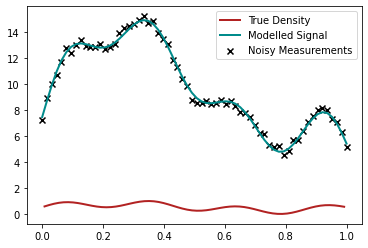

In [7]:
# Set the model parameters.
depth = 0.1
quadrature_degree = 64
n_data = 64
datapoints = np.linspace(0,1,n_data)
noise_level = 0.2

# Initialise a model
model_true = Gravity(f, depth, quadrature_degree, datapoints)

# Add noise to the data.
np.random.seed(123)
noise = np.random.normal(0, noise_level, n_data)
data = model_true.g + noise

# Plot density, noiseless signal and noisy measurements.
print('True Density, Signal and Noisy Measurements')
plt.figure(figsize=(6,4))
plt.plot(model_true.t, model_true.f, label='True Density', linewidth=2, c='firebrick')
plt.plot(model_true.s, model_true.g, label='Modelled Signal', linewidth=2, c='darkcyan')
plt.scatter(model_true.s, data, label='Noisy Measurements', c='k', marker='x')
plt.legend(loc=1)
plt.show()

In [8]:
class Gravity_Forward(Gravity):
    '''
    Gravity forward is a class that implements the gravity problem,
    but computation of signal and density is delayed to the "solve"
    method, since it relied on a Gaussian Random Field to model
    the (unknown) density.
    '''
    def __init__(self, depth, n_quadrature, datapoints):
        
        # Set the depth of the density (distance to the surface measurements).
        self.d = depth
        
        # Set the quadrature degree.
        self.n = n_quadrature
        
        # Set the quadrature points.
        x = np.linspace(0,1,self.n+1)
        self.t = (x[1:] + x[:-1]) / 2
        
        # Set the quadrature weights.
        self.w = 1/self.n
        
        # Set the datapoints.
        self.s = datapoints
        
        # Create the kernel of the discrete Fremholm integral.
        tt, ss = np.meshgrid(self.t, self.s)
        self.K = self.w*self.d / (self.d**2 + (ss-tt)**2)**(3/2)
        
    def set_random_process(self, random_process, lamb, mkl):
        
        # Set the number of KL modes.
        self.mkl = mkl
        
        # Initialise a random process on the quadrature points.
        # and compute the eigenpairs of the covariance matrix,
        self.random_process = random_process(np.c_[self.t, np.zeros(len(self.t))], self.mkl, lamb)
        self.random_process.compute_eigenpairs()
    
    def solve(self, parameters):
        
        # Internalise the Random Field parameters
        self.parameters = parameters
        
        # Create a realisation of the random process, given the parameters.
        self.random_process.generate(self.parameters)
        mean = 0.0; stdev = 1.0;
        
        # Set the density.
        self.f = mean + stdev*self.random_process.random_field
        
        # Compute the signal.
        self.g = np.dot(self.K, self.f)
        
    def get_data(self):
        
        # Get the data vector.
        return self.g

In [9]:
# We project the eigenmodes of the fine model to the quadrature points
# of the coarse model using linear interpolation.
def project_eigenmodes(model_coarse, model_fine):
    model_coarse.random_process.eigenvalues = model_fine.random_process.eigenvalues 
    for i in range(model_coarse.mkl):
        interpolator = interp1d(model_fine.t, model_fine.random_process.eigenvectors[:,i])
        model_coarse.random_process.eigenvectors[:,i] = interpolator(model_coarse.t)

Level 0:


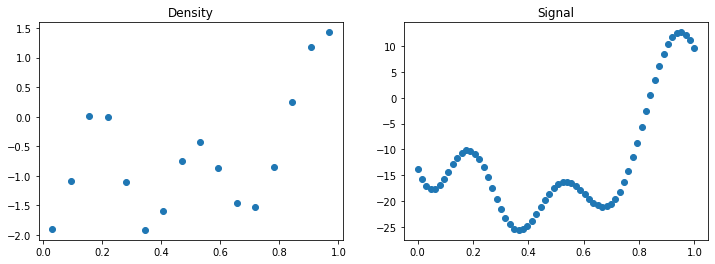

Level 1:


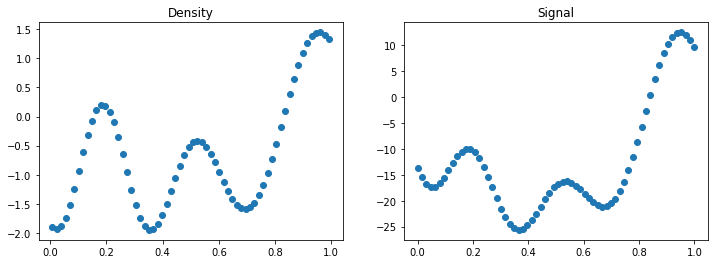

In [10]:
# Set random process parameters.
lamb = 0.1
mkl = 8

# Set the quadrature degree for each model level (coarsest first)
n_quadrature = [16, 64]

# Initialise the models, according the quadrature degree.
my_models = []
for i, n_quad in enumerate(n_quadrature):
     my_models.append(Gravity_Forward(depth, n_quad, datapoints))
     my_models[i].set_random_process(Matern52, lamb, mkl)
    
# Project the eigenmodes of the fine model to the coarse models.
for m in my_models[:-1]:
    project_eigenmodes(m, my_models[-1])

# Plot the same random realisation for each level, and the corresponding signal,
# to validate that the levels are equivalents.
for i, m in enumerate(my_models):
    print('Level {}:'.format(i))
    np.random.seed(1)
    m.solve(np.random.normal(size=mkl))
    #m.plot_kernel()
    m.plot_model()

In [11]:
# Number of draws from the distribution
ndraws = 5000

# Number of burn-in samples
nburn = 1000

# MLDA and Metropolis tuning parameters
tune = True
tune_interval = 100
discard_tuning = True

# Number of independent chains. 
# Set the number of KL modes to accomodate the minimum requirement of the DEM sampler.
nchains = 4

# Subsampling rate for MLDA
nsub = 4

# Do blocked/compounds sampling in Metropolis and MLDA 
# Note: This choice applies only to the coarsest level in MLDA 
# (where a Metropolis sampler is used), all other levels use block sampling
blocked = True

# Set prior parameters for multivariate Gaussian prior distribution.
mu_prior = np.zeros(mkl)
cov_prior = np.eye(mkl)

# Set the sigma for inference.
# Since there is some discrepancy between the fine and coarse models,
# we inflate the uncertainty of the coarse sampler slightly.
# This will not bias the resulting fine chain, since it is corrected
# by the second acceptance ratio.
sigma = [0.15, 0.10]

# Data generation seed
data_seed = 1234

# Sampling seed
sampling_seed = 1234

In [12]:
def my_loglik(my_model, theta, data, sigma):
    """
    This returns the log-likelihood of my_model given theta,
    datapoints, the observed data and sigma. It uses the
    model_wrapper function to do a model solve.
    """
    my_model.solve(theta)
    output = my_model.get_data()
    return - (0.5 / sigma ** 2) * np.sum((output - data) ** 2)

class LogLike(tt.Op):
    """
    Theano Op that wraps the log-likelihood computation, necessary to
    pass "black-box" fenics code into pymc3.
    Based on the work in:
    https://docs.pymc.io/notebooks/blackbox_external_likelihood.html
    https://docs.pymc.io/Advanced_usage_of_Theano_in_PyMC3.html
    """

    # Specify what type of object will be passed and returned to the Op when it is
    # called. In our case we will be passing it a vector of values (the parameters
    # that define our model and a model object) and returning a single "scalar"
    # value (the log-likelihood)
    itypes = [tt.dvector]  # expects a vector of parameter values when called
    otypes = [tt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, my_model, loglike, data, sigma):
        """
        Initialise the Op with various things that our log-likelihood function
        requires. Below are the things that are needed in this particular
        example.

        Parameters
        ----------
        my_model:
            A Model object (defined in model.py) that contains the parameters
            and functions of out model.
        loglike:
            The log-likelihood function we've defined, in this example it is
            my_loglik.
        data:
            The "observed" data that our log-likelihood function takes in. These
            are the true data generated by the finest model in this example.
        x:
            The dependent variable (aka 'x') that our model requires. This is
            the datapoints in this example.
        sigma:
            The noise standard deviation that our function requires.
        """
        # add inputs as class attributes
        self.my_model = my_model
        self.likelihood = loglike
        self.data = data
        self.sigma = sigma

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        theta = inputs  # this will contain my variables

        # call the log-likelihood function
        logl = self.likelihood(self.my_model, theta, self.data, self.sigma)

        outputs[0][0] = np.array(logl) # output the log-likelihood

In [13]:
# create Theano Ops to wrap likelihoods of all model levels and store them in list
logl = []
for i, m_i in enumerate(my_models):
    logl.append(LogLike(m_i, my_loglik, data, sigma[i]))

In [14]:
# Set up models in pymc3 for each level - excluding finest model level
coarse_models = []
for j in range(len(my_models) - 1):
    with pm.Model() as model:
        
        # Multivariate normal prior.
        theta = pm.MvNormal('theta', mu=mu_prior, cov=cov_prior, shape=mkl)
        #theta = pm.Uniform('theta', upper=3, lower=-3, shape=mkl)
        
        # Use the Potential class to evaluate likelihood (DensityDist appears to be broken)
        pm.Potential('likelihood', logl[j](theta))
        
    coarse_models.append(model)

In [15]:
# Set up finest model and perform inference with PyMC3, using the MLDA algorithm
# and passing the coarse_models list created above.
method_names = []
traces = []
runtimes = []

with pm.Model() as model:
    
    # Multivariate normal prior.
    theta = pm.MvNormal('theta', mu=mu_prior, cov=cov_prior, shape=mkl)
    
    # Use the Potential class to evaluate likelihood (DensityDist appears to be broken)
    pm.Potential('likelihood', logl[-1](theta))
    
    # Find the MAP estimate for convergence diagnostics. 
    # It is NOT used as starting point for sampling.
    MAP = pm.find_MAP()
    
    # Initialise an MLDA step method object, passing the subsampling rate and
    # coarse models list
    # Also initialise a Metropolis step method object
    step_metropolis = pm.Metropolis(tune=tune, tune_interval=tune_interval, blocked=blocked)
    step_demetropolis = pm.DEMetropolis(tune='scaling', tune_interval=tune_interval)
    step_mlda = pm.MLDA(subsampling_rates=nsub, coarse_models=coarse_models,
                        tune=tune, tune_interval=tune_interval, base_blocked=blocked,
                        base_sampler='Metropolis')
    #step_mlda_dem = pm.MLDA(subsampling_rates=nsub, coarse_models=coarse_models,
    #                    tune=tune, tune_interval=tune_interval, base_blocked=blocked,
    #                    base_sampler='DEMetropolisZ')

    # Inference!
    # Metropolis
    t_start = time.time()
    method_names.append("Metropolis")
    traces.append(pm.sample(draws=ndraws, step=step_metropolis,
                            chains=nchains, tune=nburn,
                            discard_tuned_samples=discard_tuning,
                            random_seed=sampling_seed))
    runtimes.append(time.time() - t_start)
    
    # DEMetropolis
    t_start = time.time()
    method_names.append("DEMetropolis")
    traces.append(pm.sample(draws=ndraws, step=step_demetropolis,
                            chains=nchains, tune=nburn,
                            discard_tuned_samples=discard_tuning,
                            random_seed=sampling_seed))
    runtimes.append(time.time() - t_start)
    
    # MLDA-Metropolis
    t_start = time.time()
    method_names.append("MLDA-Metropolis")
    traces.append(pm.sample(draws=ndraws, step=step_mlda,
                            chains=nchains, tune=nburn,
                            discard_tuned_samples=discard_tuning,
                            random_seed=sampling_seed))
    runtimes.append(time.time() - t_start)
    
    ## MLDA-DEMetropolis
    #t_start = time.time()
    #method_names.append("MLDA-DEMetropolis")
    #traces.append(pm.sample(draws=ndraws, step=step_mlda_dem,
    #                        chains=nchains, tune=nburn,
    #                        discard_tuned_samples=discard_tuning,
    #                        random_seed=sampling_seed))
    #runtimes.append(time.time() - t_start)

/home/mikkel/venv/pymc3_mlda_develop/lib/python3.6/site-packages/pymc3/step_methods/metropolis.py:989: UserWarning: The MLDA implementation in PyMC3 is very young. You should be extra critical about its results.
  'The MLDA implementation in PyMC3 is very young. '
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 4 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Population sampling (4 chains)
/home/mikkel/venv/pymc3_mlda_develop/lib/python3.6/site-packages/pymc3/sampling.py:580: UserWarning: DEMetropolis should be used with more chains than dimensions! (The model has 8 dimensions.)
  UserWarning,
DEMetropolis: [theta]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 8 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
MLDA: [theta]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 32 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [16]:
# Print MAP estimate and pymc3 sampling summary
# I put this (and the following diagnostics) in the pm.Model() context 
# to suppress the (many) deprecation warnings.
with model:
    print(f"\nDetailed summaries and plots:\nMAP estimate: {MAP['theta']}. Not used as starting point.")
    for i, trace in enumerate(traces):
        print(f"\n{method_names[i]} Sampler:\n") 
        display(pm.stats.summary(trace))


Detailed summaries and plots:
MAP estimate: [-1.05809514  0.40540974 -0.4315388  -0.10871192  0.36779126 -0.06846585
 -0.9496934  -0.00569455]. Not used as starting point.

Metropolis Sampler:



,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta[0],-1.058,0.003,-1.062,-1.052,0.001,0.000,38.0,38.0,40.0,24.0,1.56
theta[1],0.406,0.004,0.397,0.410,0.001,0.000,36.0,35.0,21.0,58.0,1.15
theta[2],-0.432,0.004,-0.440,-0.426,0.001,0.001,18.0,18.0,16.0,27.0,1.35
theta[3],-0.110,0.006,-0.120,-0.100,0.001,0.001,25.0,25.0,22.0,84.0,1.14
theta[4],0.369,0.009,0.359,0.386,0.003,0.002,10.0,10.0,10.0,5.0,1.35
theta[5],-0.070,0.014,-0.095,-0.044,0.004,0.003,10.0,10.0,9.0,19.0,1.53
theta[6],-0.942,0.023,-0.971,-0.885,0.005,0.004,22.0,22.0,23.0,24.0,1.62
theta[7],-0.076,0.104,-0.255,0.150,0.045,0.033,5.0,5.0,5.0,7.0,2.62



DEMetropolis Sampler:



,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta[0],-1.048,0.029,-1.078,-0.991,0.005,0.004,33.0,32.0,66.0,66.0,1.31
theta[1],0.417,0.027,0.391,0.479,0.005,0.004,25.0,25.0,43.0,101.0,1.41
theta[2],-0.450,0.046,-0.560,-0.389,0.009,0.006,28.0,28.0,42.0,76.0,1.45
theta[3],-0.037,0.176,-0.131,0.433,0.037,0.026,23.0,23.0,20.0,63.0,1.32
theta[4],0.403,0.090,0.336,0.664,0.016,0.012,30.0,30.0,34.0,67.0,1.20
theta[5],-0.034,0.099,-0.187,0.139,0.022,0.016,20.0,20.0,29.0,80.0,1.47
theta[6],-1.327,0.366,-1.898,-0.936,0.164,0.123,5.0,5.0,6.0,85.0,1.73
theta[7],0.132,0.223,-0.082,0.803,0.046,0.033,23.0,23.0,13.0,62.0,1.30



MLDA-Metropolis Sampler:



,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta[0],-1.058,0.001,-1.061,-1.055,0.000,0.000,795.0,795.0,798.0,769.0,1.00
theta[1],0.405,0.002,0.402,0.409,0.000,0.000,1143.0,1143.0,1138.0,1505.0,1.01
theta[2],-0.432,0.002,-0.436,-0.428,0.000,0.000,434.0,434.0,438.0,676.0,1.01
theta[3],-0.109,0.003,-0.115,-0.103,0.000,0.000,645.0,645.0,644.0,774.0,1.01
theta[4],0.368,0.005,0.359,0.377,0.000,0.000,318.0,318.0,318.0,600.0,1.01
theta[5],-0.068,0.007,-0.084,-0.057,0.001,0.000,143.0,142.0,142.0,172.0,1.02
theta[6],-0.950,0.010,-0.969,-0.930,0.001,0.001,76.0,76.0,76.0,193.0,1.09
theta[7],-0.011,0.018,-0.042,0.029,0.004,0.003,17.0,17.0,18.0,44.0,1.19


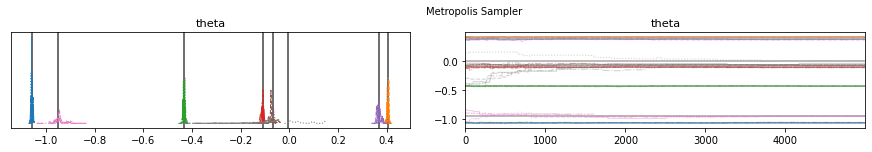

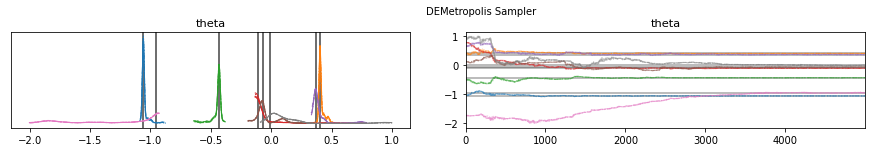

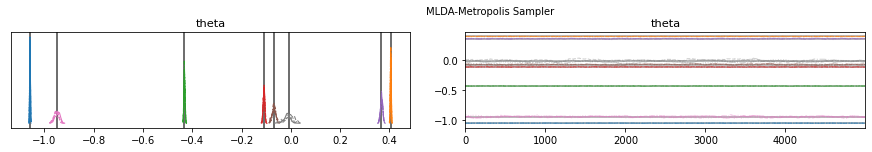

In [17]:
# Plot distributions and trace.
# Vertical grey lines represent the MAP estimate of each parameter.
with model:
    lines= (('theta',{}, MAP['theta'].tolist()),)
    for i, trace in enumerate(traces):
        pm.plots.traceplot(trace, lines=lines)
        
        # Ugly hack to get some titles in.
        x_offset = -0.1*ndraws
        y_offset = trace.get_values('theta').max() + 0.25*(trace.get_values('theta').max()-trace.get_values('theta').min())
        plt.text(x_offset, y_offset, '{} Sampler'.format(method_names[i]))


Metropolis Sampler: 5000 drawn samples in each of 4 chains.
Runtime: 4.577809572219849 seconds
Acceptance rate: 0.00475
ESS list: [39.579 20.594 16.278 21.939  9.763  9.184 23.341  4.713]
Normalised ESS list: [0.002 0.001 0.001 0.001 0.    0.    0.001 0.   ]
ESS/sec: [8.646 4.499 3.556 4.793 2.133 2.006 5.099 1.03 ]

DEMetropolis Sampler: 5000 drawn samples in each of 4 chains.
Runtime: 8.670586824417114 seconds
Acceptance rate: 0.3474
ESS list: [65.784 43.489 42.189 19.775 33.974 29.273  6.301 12.595]
Normalised ESS list: [0.003 0.002 0.002 0.001 0.002 0.001 0.    0.001]
ESS/sec: [7.587 5.016 4.866 2.281 3.918 3.376 0.727 1.453]

MLDA-Metropolis Sampler: 5000 drawn samples in each of 4 chains.
Runtime: 32.22079300880432 seconds
Acceptance rate: 0.11625
ESS list: [ 797.614 1137.646  438.274  644.17   317.867  142.328   75.526   17.772]
Normalised ESS list: [0.04  0.057 0.022 0.032 0.016 0.007 0.004 0.001]
ESS/sec: [24.755 35.308 13.602 19.992  9.865  4.417  2.344  0.552]


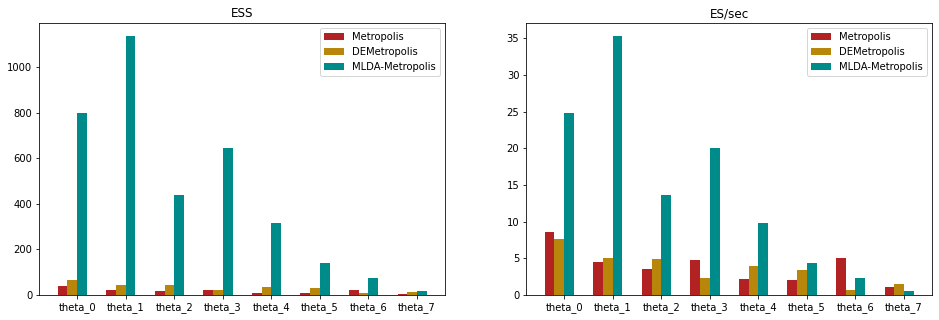

In [18]:
acc = []
ess = []
ess_n = []
performances = []

# Get some more statistics.
with model:
    for i, trace in enumerate(traces):
        acc.append(trace.get_sampler_stats('accepted').mean())
        ess.append(np.array(pm.ess(trace).to_array()))
        ess_n.append(ess[i] / len(trace) / trace.nchains)
        performances.append(ess[i] / runtimes[i])
        print(f'\n{method_names[i]} Sampler: {len(trace)} drawn samples in each of '
              f'{trace.nchains} chains.'
              f'\nRuntime: {runtimes[i]} seconds'
              f'\nAcceptance rate: {acc[i]}'
              f'\nESS list: {np.round(ess[i][0], 3)}'
              f'\nNormalised ESS list: {np.round(ess_n[i][0], 3)}'
              f'\nESS/sec: {np.round(performances[i][0], 3)}')
    
    # Plot the effective sample size (ESS) and relative ESS (ES/sec) of each of the sampling strategies.
    colors = ['firebrick', 'darkgoldenrod', 'darkcyan', 'olivedrab']
    
    fig, axes = plt.subplots(1,2, figsize=(16,5))
    
    axes[0].set_title('ESS')
    for i, e in enumerate(ess):
        axes[0].bar([j+i*0.2 for j in range(mkl)], e.ravel(), width=0.2, color=colors[i], label=method_names[i])
    axes[0].set_xticks([i+0.3 for i in range(mkl)]); axes[0].set_xticklabels(['theta_{}'.format(i) for i in range(mkl)])
    axes[0].legend()
    
    axes[1].set_title('ES/sec')
    for i, p in enumerate(performances):
        axes[1].bar([j+i*0.2 for j in range(mkl)], p.ravel(), width=0.2, color=colors[i], label=method_names[i])
    axes[1].set_xticks([i+0.3 for i in range(mkl)]); axes[1].set_xticklabels(['theta_{}'.format(i) for i in range(mkl)])
    axes[1].legend()
    plt.show()

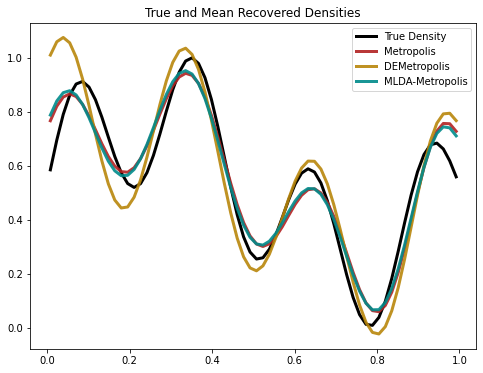

In [19]:
# Plot true and recovered densities
with model:
    
    colors = ['firebrick', 'darkgoldenrod', 'darkcyan', 'olivedrab']
    
    plt.figure(figsize=(8,6))
    plt.title('True and Mean Recovered Densities')
    plt.plot(model_true.t, model_true.f, label='True Density', linewidth=3, c='k')
    for i, t in enumerate(traces):
        my_models[-1].solve(pm.stats.summary(t)['mean'].values)
        plt.plot(my_models[-1].t, my_models[-1].f, label=method_names[i], linewidth=3, c=colors[i], alpha=0.9)
    plt.legend(loc=1)
    plt.show()